In [16]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline

from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
import xgboost as xgb


from sklearn.metrics import accuracy_score, f1_score, classification_report
import warnings
warnings.filterwarnings("ignore")

# Загрузка данных
df = pd.read_csv('https://raw.githubusercontent.com/datasciencedojo/datasets/master/titanic.csv')
df.head()


,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [3]:
import tensorflow as tf
print(tf.__version__)


2.19.0


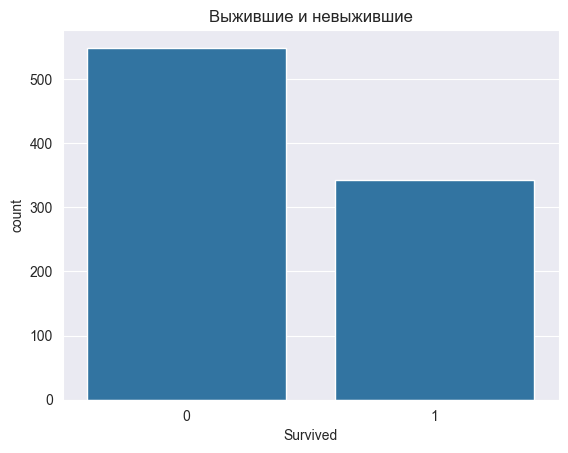

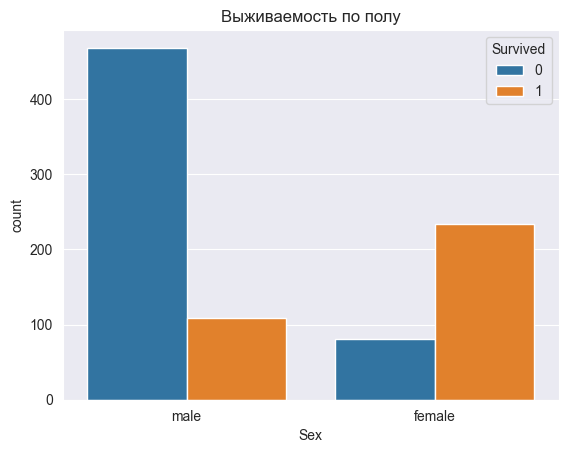

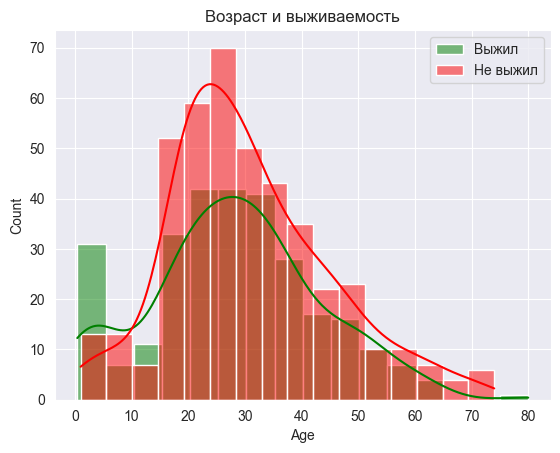

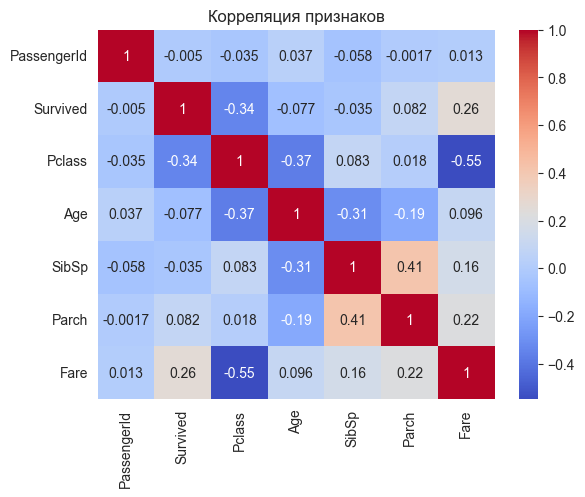

In [17]:
# Пропуски
df.isnull().sum()

# Распределение выживших
sns.countplot(data=df, x='Survived')
plt.title('Выжившие и невыжившие')
plt.show()

# Пол и выживаемость
sns.countplot(data=df, x='Sex', hue='Survived')
plt.title('Выживаемость по полу')
plt.show()

# Возраст и выживаемость
sns.histplot(df[df['Survived']==1]['Age'], label='Выжил', kde=True, color='green')
sns.histplot(df[df['Survived']==0]['Age'], label='Не выжил', kde=True, color='red')
plt.legend()
plt.title('Возраст и выживаемость')
plt.show()

# Корреляционная матрица
sns.heatmap(df.corr(numeric_only=True), annot=True, cmap='coolwarm')
plt.title('Корреляция признаков')
plt.show()

In [12]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler

# Загрузка данных
df = pd.read_csv('https://raw.githubusercontent.com/datasciencedojo/datasets/master/titanic.csv')

# Проверка наличия столбцов
print(df.columns)

# Признаки
df['FamilySize'] = df['SibSp'] + df['Parch'] + 1
df['IsAlone'] = (df['FamilySize'] == 1).astype(int)
df['Title'] = df['Name'].str.extract(' ([A-Za-z]+)\.', expand=False)
df['Title'] = df['Title'].replace(['Mlle', 'Ms', 'Mme', 'Lady', 'Countess', 'Dona'], 'Rare')
df['Deck'] = df['Cabin'].str[0]

# Заполнение пропусков
df['Age'].fillna(df['Age'].median(), inplace=True)
df['Embarked'].fillna(df['Embarked'].mode()[0], inplace=True)
df['Fare'].fillna(df['Fare'].median(), inplace=True)
df['Deck'].fillna('U', inplace=True)

# Кодирование
cat_cols = ['Sex', 'Embarked', 'Title', 'Deck']
df = pd.get_dummies(df, columns=cat_cols, drop_first=True)

# Целевой признак
y = df['Survived']
X = df.drop(columns=['Survived', 'Name', 'Ticket', 'Cabin', 'PassengerId'])

# Масштабирование
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Проверка результата
print(X_scaled[:1])  # Вывод первых 5 строк масштабированных данных

Index(['PassengerId', 'Survived', 'Pclass', 'Name', 'Sex', 'Age', 'SibSp',
       'Parch', 'Ticket', 'Fare', 'Cabin', 'Embarked'],
      dtype='object')
[[ 0.82737724 -0.56573646  0.43279337 -0.47367361 -0.50244517  0.05915988
  -1.2316449   0.73769513 -0.30756234  0.61583843 -0.0474312  -0.03352008
  -0.08898625 -0.03352008 -0.0474312  -0.21680296 -0.50665528  0.85053175
  -0.4039621  -0.0823387  -0.0823387  -0.03352008 -0.23598136 -0.26629582
  -0.19611614 -0.19300938 -0.12168146 -0.06715343 -0.03352008  0.54492498]]


In [15]:
models = {
    "LogisticRegression": LogisticRegression(),
    "DecisionTree": DecisionTreeClassifier(),
    "RandomForest": RandomForestClassifier(),
    "XGBoost": xgb.XGBClassifier(use_label_encoder=False, eval_metric='logloss')
}

skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

for name, model in models.items():
    scores = cross_val_score(model, X_scaled, y, cv=skf, scoring='accuracy')
    print(f"{name} | Accuracy: {scores.mean():.4f} (+/- {scores.std():.4f})")

LogisticRegression | Accuracy: 0.8238 (+/- 0.0163)
DecisionTree | Accuracy: 0.7923 (+/- 0.0275)
RandomForest | Accuracy: 0.8159 (+/- 0.0122)
XGBoost | Accuracy: 0.8283 (+/- 0.0266)


In [13]:
model_nn = Sequential([
    Dense(32, input_dim=X_scaled.shape[1], activation='relu'),
    Dense(16, activation='relu'),
    Dense(1, activation='sigmoid')
])

model_nn.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

# Валидация
from sklearn.model_selection import KFold
kf = KFold(n_splits=5, shuffle=True, random_state=42)
nn_scores = []

for train_idx, val_idx in kf.split(X_scaled):
    X_train, X_val = X_scaled[train_idx], X_scaled[val_idx]
    y_train, y_val = y.iloc[train_idx], y.iloc[val_idx]

    model_nn.fit(X_train, y_train, epochs=30, batch_size=32, verbose=0)
    loss, acc = model_nn.evaluate(X_val, y_val, verbose=0)
    nn_scores.append(acc)

print(f"Neural Network | Accuracy: {np.mean(nn_scores):.4f} (+/- {np.std(nn_scores):.4f})")

Neural Network | Accuracy: 0.8496 (+/- 0.0295)
